### Download Sentinel-1 data

Get all images from 2023 - 2024 IW, GRD, VV polarization, high resolution at buoy locations

In [2]:
import ee 
import geemap
import math
import numpy as np
import pandas as pd
import os
import glob 
import zipfile
import seaborn as sns
import rioxarray

home = "C:/Users/kmcquil/Documents/SWOT_WIND/"

In [2]:
#ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [9]:
# Filter the image collection 
# Load the sentinel 1 dataset and filter to GRD, IW, and VV polarization, years 2023-2024, and intersects with buoy locations 
buoys_shp_fp = os.path.join(home, "Data/Buoy/buoy_info.shp")
buoys = geemap.shp_to_ee(buoys_shp_fp)

start_date = '2023-01-01'
end_date = '2024-04-01'

sentinel1_vv = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.eq('instrumentMode', 'IW')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.date(start_date, end_date)) \
.filter(ee.Filter.eq('resolution', 'H')) \
.filterBounds(buoys)

count = sentinel1_vv.size()
count
# 1373 images 

In [10]:
# Convert to type double for both bands so that they can be exported together 
def double(image):
    return image.double()
sentinel1_vv = sentinel1_vv.map(double)

In [33]:
sentinel1_vv.first()

In [11]:
# Export image collection to drive 
# change the scale to 100m 
# I exported this to kmcquillan449@gmail.com since I payed for 1TB of stroage
geemap.ee_export_image_collection_to_drive(sentinel1_vv, folder='S1', scale=100, maxPixels=10000000000000)

Total number of images: 1373



In [16]:
# Create a panda dt of the S1 image id, orbit direction, and orbit heading 
def get_properties(image):
    # Extract the system:id 
    id = image.get('system:id').getInfo()

    # Extract orbit direction 
    orbit_pass = image.get('orbitProperties_pass').getInfo()

    # Find the most eastern, most southern, and most northern point 
    coords = image.get('system:footprint').getInfo()['coordinates']
    x = [i[0] for i in coords]
    y = [i[1] for i in coords]

    east_idx = x.index(max(x))
    east_coord = coords[east_idx]

    south_idx = y.index(min(y))
    south_coord = coords[south_idx]

    north_idx = y.index(max(y))
    north_coord = coords[north_idx]

    if orbit_pass == "ASCENDING":
        # from east to north 
        angle = math.degrees(math.atan2(north_coord[1]-east_coord[1], north_coord[0]-east_coord[0]))
        orbit_heading = (90-angle)%360

    if orbit_pass == "DESCENDING":
        # from east to south 
        angle = math.degrees(math.atan2(south_coord[1]-east_coord[1], south_coord[0]-east_coord[0]))
        orbit_heading = (90-angle)%360

    dt = pd.DataFrame({'id':[id], 'orbit_pass':[orbit_pass], 'orbit_heading':[orbit_heading]})
    return dt 

# Convert to list for iteration 
s1_props = []
sentinel1_vv_list = sentinel1_vv.toList(count)
for i in range(0,1373):
    image = ee.Image(ee.List(sentinel1_vv_list).get(i))
    s1_props.append(get_properties(image))

s1_props_df = pd.concat(s1_props)
s1_props_df.to_csv(os.path.join(home, "Data/Sentinel1/s1_image_info.csv"))

<Axes: xlabel='orbit_heading', ylabel='Count'>

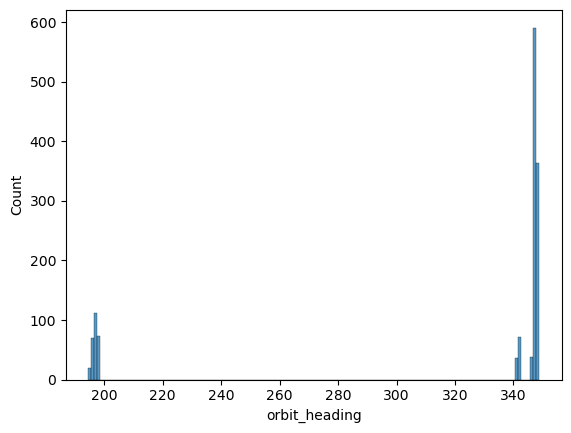

In [26]:
# Visualize the orbit headings 
sns.histplot(s1_props_df['orbit_heading'])

In [ ]:
# Map the footprint 
coords = image.get('system:footprint').getInfo()
system_footprint = ee.Geometry.LinearRing(coords['coordinates'])

Map = geemap.Map()
Map.addLayer(system_footprint, {}, "Footprint")
Map

In [24]:
# After downloading all of the sentinel 1 data from personal GDRIVE, it must be unzipped and put in the right location 
zip_files = glob.glob('C:/Users/kmcquil/Downloads/S1-*.zip')
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(home, "Data/Sentinel1/Raw"))

In [3]:
# Process all of the sentinel images downloaded to linear units 
def process_sentinel(vv_fp):

    # Open and rename bands of the file 
    ds = rioxarray.open_rasterio(vv_fp, band_as_variable = True)
    ds = ds.rename({'band_1': 'sig0', 'band_2':'vh', 'band_3': 'inc_angle'})

    # Drop the vh band 
    ds = ds.drop_vars('vh')

    # Convert the vv sigma0 from dB to linear 
    ds['sig0'] = 10 ** (ds['sig0']/10)

    # Set the no data value
    ds.sig0.rio.write_nodata(np.nan, encoded=True, inplace=True)
    ds.inc_angle.rio.write_nodata(np.nan, encoded=True, inplace=True)

    # There is no water mask. This dataset will just use the lake boundary to mask out non-water pixels 
    # Add the platform heading as an attribute 
    orbit_heading = s1_props_df[s1_props_df['id'].str.contains(os.path.basename(vv_fp)[:-4])]['orbit_heading'].iloc[0]
    ds.rio.update_attrs({'platform_heading':orbit_heading}, inplace=True)
    # Write the crs again because it gets lost 
    ds.rio.write_crs(ds.rio.crs, inplace=True)
    # Save as a .nc file to preserve the platform_heading attribute 
    ds.to_netcdf(os.path.join(home, "Data/Sentinel1/Processed",  os.path.basename(vv_fp)[:-4] + ".nc"))
    ds.close()
    return "finished " + vv_fp


In [4]:
s1_props_df = pd.read_csv(os.path.join(home, "Data/Sentinel1/s1_image_info.csv"))
s1_files = glob.glob(os.path.join(home, "Data/Sentinel1/Raw/S1/*.tif"))

for file in s1_files:
    if os.path.isfile(os.path.join(home, "Data/Sentinel1/Processed",  os.path.basename(file)[:-4] + ".nc")) == True:
        continue
    process_sentinel(file)